# Self organizing maps
Should not do any dimensionality reduction beforehand

In [408]:
import sys
import os
from pathlib import Path
import numbers
import random
import json
from itertools import chain
print(sys.executable)
print(sys.version)
sys.path.extend(['..', '../..'])
from tqdm import tqdm_notebook
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
import seaborn as sns
from sklearn.preprocessing import minmax_scale, StandardScaler
from sklearn.decomposition import PCA, FastICA
from sklearn.ensemble import IsolationForest
from sklearn.mixture import GaussianMixture
from sklearn.ensemble import ExtraTreesRegressor, ExtraTreesClassifier
from sklearn.neighbors import NearestNeighbors
from xgboost import XGBClassifier
from sklearn.feature_selection import SelectFromModel
from sklearn.model_selection import train_test_split
from sklearn.manifold import TSNE
from sklearn.feature_selection import SelectKBest, chi2
from skimage import transform, color
import cv2
import imageio
from quant.experiment.clustering import Clustering
from base.data.wsi_reader import WSIReader
from sompy.sompy import SOMFactory
import joblib
import umap
import markov_clustering as mc
import tqdm
sns.set(style="darkgrid")

/well/rittscher/users/achatrian/.conda/envs/pyenvclone/bin/python
3.7.3 (default, Mar 27 2019, 22:11:17) 
[GCC 7.3.0]


In [409]:
from PIL import Image
from PIL import ImageFont
from PIL import ImageDraw

In [3]:
def sub_train_som(data, mapsize):
    sm = SOMFactory.build(data,
                          mapsize=mapsize,
                          normalization=None,
                          initialization='random',
                          lattice="rect")
    sm.train(n_job=1, verbose='info', train_rough_len=30, train_finetune_len=100)
    return sm

In [4]:
def train_som_para(data, mapsize, save_folder):
    if not os.path.exists(save_folder):
        os.makedirs(save_folder)

    savename = os.path.join(save_folder, 'model.joblib')
    if not os.path.exists(savename):
        # SOM

        sm_set = Parallel(n_jobs=4)(delayed(sub_train_som)(data, mapsize) for _ in range(50))
        sm_idx = np.argmin([sm.calculate_topographic_error() for sm in sm_set])
        sm = sm_set[sm_idx]
        joblib.dump(sm, savename)

    else:
        sm = joblib.load(savename)

    return sm

In [5]:
def train_som(data, mapsize, save_folder, train_rough_len=30, train_finetune_len=100):
    # sequential version of above
    if not os.path.exists(save_folder):
        os.makedirs(save_folder)

    savename = os.path.join(save_folder, 'model.joblib')
    if not os.path.exists(savename):
        # SOM
        sm = SOMFactory.build(data,
                              mapsize=mapsize,
                              normalization=None,
                              initialization='pca',
                              lattice="rect")
        sm.train(n_job=1, verbose='info', train_rough_len=train_rough_len, train_finetune_len=train_finetune_len)
        joblib.dump(sm, savename)
    else:
        sm = joblib.load(savename)

    return sm

In [6]:
x = pd.read_hdf('/well/rittscher/projects/prostate-gland-phenotyping/WSI/data/features/all.h5', 'x')

In [7]:
cont=0.05
c1 = Clustering('', x=x, outlier_removal=IsolationForest(contamination=cont))
c1.remove_outliers()
x = c1.x

/well/rittscher/users/achatrian/.conda/envs/pyenvclone/lib/python3.7/site-packages/sklearn/ensemble/iforest.py:247: FutureWarning: behaviour="old" is deprecated and will be removed in version 0.22. Please use behaviour="new", which makes the decision_function change to match other anomaly detection algorithm API.
  FutureWarning)
/well/rittscher/users/achatrian/.conda/envs/pyenvclone/lib/python3.7/site-packages/sklearn/ensemble/iforest.py:415: DeprecationWarning: threshold_ attribute is deprecated in 0.20 and will be removed in 0.22.
  " be removed in 0.22.", DeprecationWarning)


Removed 968 outliers through IsolationForest(behaviour='old', bootstrap=False, contamination=0.05,
                max_features=1.0, max_samples='auto', n_estimators=100,
                n_jobs=None, random_state=None, verbose=0, warm_start=False)


In [8]:
to_reg_prop = 24
to_haralick=76
x = x.iloc[:, 0:to_haralick]
x.shape

(18379, 76)

In [9]:
mapsize=22
save_folder='/well/rittscher/users/achatrian/temp'
sm = train_som(x, (mapsize, mapsize), save_folder, 90, 50)

In [10]:
sm.codebook.matrix.shape

(484, 76)

n_neighbour 30


update_title_pos
update_title_pos
update_title_pos
update_title_pos


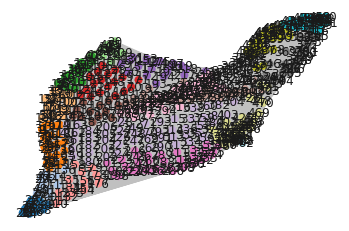

In [435]:
save_folder='/well/rittscher/users/achatrian/temp'
savename = os.path.join(save_folder, 'cluster_assignment.joblib')
if not os.path.exists(savename):
    codebooks = sm.codebook.matrix
    best_Q = []
    all_clusters = []
    all_matrix = []
    all_neighbours = []
    upper_limit=21
    for n_neighbour in [30]:#range(10, 31, 5):
        print('n_neighbour %d' % n_neighbour)
        matrix = umap.umap_.fuzzy_simplicial_set(X=codebooks, n_neighbors=n_neighbour, random_state=np.random.RandomState(0),
                                                 metric='euclidean')

        all_inflation = []
        all_Q = []
        for inflation in tqdm_notebook([i / 10 for i in range(11, 30)]):
            result = mc.run_mcl(matrix, inflation=inflation)
            clusters = mc.get_clusters(result)
            Q = mc.modularity(matrix=result, clusters=clusters)

            all_inflation.append(inflation)
            all_Q.append(Q)

        best_Q.append(np.max(all_Q))
        result = mc.run_mcl(matrix, inflation=all_inflation[np.argmax(all_Q)])  # run MCL with default parameters
        clusters = mc.get_clusters(result)
        all_clusters.append(clusters)
        all_matrix.append(matrix)
        all_neighbours.append(n_neighbour)
        # mc.draw_graph(matrix, clusters, pos=embedding, node_size=50, with_labels=False, edge_color="silver")

    clusters = all_clusters[np.argmax(best_Q)]
    matrix = all_matrix[np.argmax(best_Q)]
    n_neighbour = all_neighbours[np.argmax(best_Q)]
    embedding_umap = umap.UMAP(n_neighbors=n_neighbour,
                          min_dist=0.3,
                          metric='euclidean').fit_transform(codebooks)

    all_membership = np.vstack([[[x, idx] for x in cluster] for idx, cluster in enumerate(clusters)])
    sort_order = all_membership[:, 0].argsort()
    all_membership = all_membership[sort_order]
    P = all_membership[:, 1]

    mc.draw_graph(matrix, clusters, pos=embedding_umap, node_size=50, with_labels=True, edge_color="silver")
    plt.savefig(os.path.join(save_folder, 'mcl.png'))  # not working on notebook
    plt.close()

    joblib.dump({'embedding_umap': embedding_umap, 'matrix': matrix, 'clusters': clusters, 'P': P}, savename)
else:
    P = joblib.load(savename)['P']

In [436]:
np.unique(P)

array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16,
       17, 18, 19])

In [437]:
savename = os.path.join(save_folder, 'sm_grid_label.png')
############################################################################
nbrs = NearestNeighbors(n_neighbors=1, algorithm='ball_tree').fit(sm.codebook.matrix)
distance, indices = nbrs.kneighbors(x)  # find nearest SOM cluster for each data-point
distance = distance.ravel()
indices = indices.ravel()

In [438]:
y = pd.Series(data=[P[idx] for idx in indices], index=x.index)

In [439]:
print(len(P), np.unique(P))
membership_numbers = []
for p in np.unique(P):
    membership_numbers.append(np.sum(y == p))
    print(p, np.sum(y == p))  # same cluster but different drawing above

484 [ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19]
0 1441
1 1088
2 2024
3 1898
4 1627
5 859
6 982
7 625
8 702
9 1560
10 406
11 1055
12 960
13 835
14 612
15 432
16 472
17 461
18 339
19 1


In [16]:
clusters = list(p for p in np.unique(P) if membership_numbers[p] > 10)
c = Clustering('markov', x=x, y=y, clusters=clusters)
c.clusters

[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18]

In [17]:
cluster_centers = []
for i in c.clusters:
    cluster_centers.append(
        sm.codebook.matrix[np.where(P == i)[0]]
    )
    print(cluster_centers[-1].shape)

(16, 76)
(16, 76)
(29, 76)
(23, 76)
(20, 76)
(17, 76)
(18, 76)
(16, 76)
(21, 76)
(52, 76)
(12, 76)
(34, 76)
(36, 76)
(32, 76)
(29, 76)
(21, 76)
(29, 76)
(36, 76)
(24, 76)


In [376]:
from tqdm import tqdm
import warnings
from scipy.spatial.distance import cdist
def get_examples(self, image_dir=None, n_examples=5, mpp=0.2, cluster_centers=None, image_dim_increase=0.5):
    if self.x is None or self.y is None:
        raise ValueError("Data has not been read / processed yet for cluster extraction")
    if image_dir is None:
        image_dir = Path(self.loaded_paths[0]).parents[2]
        assert (image_dir / 'data').is_dir(), "image_dir should contain dir 'data'"
    if self.clusters is None:
        self.clusters = np.unique(self.y)
    examples = []
    for i, cluster in enumerate(tqdm(self.clusters, desc='clusters')):
        x_cluster = self.x.iloc[(self.y == cluster).to_numpy().squeeze()]
        examples.append([])
        if cluster_centers is None:
            sample_index = tuple(
                x_cluster.sample(n=n_examples, replace=False).index)  # randomly sample examples
            if len(sample_index) < n_examples:
                sample_index = sample_index + sample_index[:n_examples]
        else:
            closest_points_indices = []  # list of lists, each list containing the index of a close point to one cluster
            if isinstance(cluster_centers, np.ndarray) and cluster_centers.ndim == 2:
                dist = cdist(cluster_centers[i:i + 1, ...], x_cluster.to_numpy(), 'euclidean').squeeze()
                for n in range(n_examples):
                    closest_points_indices.append(int(dist.argmin()))
                    dist[closest_points_indices[-1]] = np.inf
            elif len(cluster_centers) == len(self.clusters) and cluster_centers[0].ndim == 2:
                # case where cluster is described by multiple points (e.g. som + mc)
                cc = cluster_centers[i]  #
                dist = cdist(cc, x_cluster.to_numpy(), 'euclidean').squeeze()
                for n in range(n_examples):
                    nn = n % min(n_examples, dist.shape[
                        0])  # if there are more examples than cluster protoypes cycle through them
                    closest_points_indices.append(int(dist[nn, ...].argmin()))
                    dist[:, closest_points_indices[-1]] = np.inf  # make column corresponding to example nn infinite
            else:
                raise ValueError("Invalid format for cluster_centers parameter")
            if np.unique(closest_points_indices).size != len(closest_points_indices):
                warnings.warn(f"Only {np.unique(closest_points_indices).size} unique examples were found for cluster '{cluster}'")
            sample_index = tuple(x_cluster.iloc[closest_points_indices].index)
        for subset_id, bb_s in sample_index:
            x, y, w, h = tuple(int(d) for d in bb_s.split('_'))
            x -= int(w * image_dim_increase/2)  # expand bounding box to give better view of gland
            y -= int(h * image_dim_increase/2)
            w += int(w * image_dim_increase)
            h += int(h * image_dim_increase)
            try:
                subset_path = next((image_dir / (subset_id + sfx)) for sfx in ['.ndpi', '.svs', '.dzi']
                                   if (image_dir / (subset_id + sfx)).is_file())
            except StopIteration:
                raise FileNotFoundError(f"DataFrame key: {subset_id} does not match an image file")
            reader = WSIReader(file_name=str(subset_path))
            image = np.array(reader.read_region((x, y), 0, (w, h)))  # changed level from None to 0 !!!
            if image.shape[2] == 4:  # assume 4 channels images are RGBA
                image = color.rgba2rgb(image)
            if image.max() <= 1.0 and image.min() >= 0.0:
                image = image * 255.0
            image = image.astype(np.uint8)
            examples[i].append(image)
    return examples

In [377]:
examples = get_examples(c, Path('/well/rittscher/projects/prostate-gland-phenotyping/WSI'), n_examples=10, cluster_centers=cluster_centers, image_dim_increase=0.25)

clusters:   0%|          | 0/19 [00:00<?, ?it/s]/well/rittscher/users/achatrian/cancer_phenotype/base/data/wsi_reader.py:82: UserWarning: No mpp or qc_mpp options - cannot perform quality control
  warnings.warn("No mpp or qc_mpp options - cannot perform quality control")
/well/rittscher/users/achatrian/cancer_phenotype/base/data/wsi_reader.py:82: UserWarning: No mpp or qc_mpp options - cannot perform quality control
  warnings.warn("No mpp or qc_mpp options - cannot perform quality control")


0.2270302177219788
0.2270302177219788


/well/rittscher/users/achatrian/cancer_phenotype/base/data/wsi_reader.py:82: UserWarning: No mpp or qc_mpp options - cannot perform quality control
  warnings.warn("No mpp or qc_mpp options - cannot perform quality control")
/well/rittscher/users/achatrian/cancer_phenotype/base/data/wsi_reader.py:82: UserWarning: No mpp or qc_mpp options - cannot perform quality control
  warnings.warn("No mpp or qc_mpp options - cannot perform quality control")


0.2270302177219788
0.2270302177219788


/well/rittscher/users/achatrian/cancer_phenotype/base/data/wsi_reader.py:82: UserWarning: No mpp or qc_mpp options - cannot perform quality control
  warnings.warn("No mpp or qc_mpp options - cannot perform quality control")
/well/rittscher/users/achatrian/cancer_phenotype/base/data/wsi_reader.py:82: UserWarning: No mpp or qc_mpp options - cannot perform quality control
  warnings.warn("No mpp or qc_mpp options - cannot perform quality control")


0.2270302177219788
0.2270302177219788


/well/rittscher/users/achatrian/cancer_phenotype/base/data/wsi_reader.py:82: UserWarning: No mpp or qc_mpp options - cannot perform quality control
  warnings.warn("No mpp or qc_mpp options - cannot perform quality control")
/well/rittscher/users/achatrian/cancer_phenotype/base/data/wsi_reader.py:82: UserWarning: No mpp or qc_mpp options - cannot perform quality control
  warnings.warn("No mpp or qc_mpp options - cannot perform quality control")


0.2270302177219788
0.2270302177219788


/well/rittscher/users/achatrian/cancer_phenotype/base/data/wsi_reader.py:82: UserWarning: No mpp or qc_mpp options - cannot perform quality control
  warnings.warn("No mpp or qc_mpp options - cannot perform quality control")
/well/rittscher/users/achatrian/cancer_phenotype/base/data/wsi_reader.py:82: UserWarning: No mpp or qc_mpp options - cannot perform quality control
  warnings.warn("No mpp or qc_mpp options - cannot perform quality control")


0.2270302177219788
0.2270302177219788


clusters:   5%|▌         | 1/19 [00:01<00:24,  1.37s/it]/well/rittscher/users/achatrian/cancer_phenotype/base/data/wsi_reader.py:82: UserWarning: No mpp or qc_mpp options - cannot perform quality control
  warnings.warn("No mpp or qc_mpp options - cannot perform quality control")
/well/rittscher/users/achatrian/cancer_phenotype/base/data/wsi_reader.py:82: UserWarning: No mpp or qc_mpp options - cannot perform quality control
  warnings.warn("No mpp or qc_mpp options - cannot perform quality control")
/well/rittscher/users/achatrian/cancer_phenotype/base/data/wsi_reader.py:82: UserWarning: No mpp or qc_mpp options - cannot perform quality control
  warnings.warn("No mpp or qc_mpp options - cannot perform quality control")


0.2270302177219788
0.2270302177219788
0.2270302177219788


/well/rittscher/users/achatrian/cancer_phenotype/base/data/wsi_reader.py:82: UserWarning: No mpp or qc_mpp options - cannot perform quality control
  warnings.warn("No mpp or qc_mpp options - cannot perform quality control")
/well/rittscher/users/achatrian/cancer_phenotype/base/data/wsi_reader.py:82: UserWarning: No mpp or qc_mpp options - cannot perform quality control
  warnings.warn("No mpp or qc_mpp options - cannot perform quality control")


0.2270302177219788
0.2270302177219788


/well/rittscher/users/achatrian/cancer_phenotype/base/data/wsi_reader.py:82: UserWarning: No mpp or qc_mpp options - cannot perform quality control
  warnings.warn("No mpp or qc_mpp options - cannot perform quality control")
/well/rittscher/users/achatrian/cancer_phenotype/base/data/wsi_reader.py:82: UserWarning: No mpp or qc_mpp options - cannot perform quality control
  warnings.warn("No mpp or qc_mpp options - cannot perform quality control")


0.2270302177219788
0.2270302177219788


/well/rittscher/users/achatrian/cancer_phenotype/base/data/wsi_reader.py:82: UserWarning: No mpp or qc_mpp options - cannot perform quality control
  warnings.warn("No mpp or qc_mpp options - cannot perform quality control")
/well/rittscher/users/achatrian/cancer_phenotype/base/data/wsi_reader.py:82: UserWarning: No mpp or qc_mpp options - cannot perform quality control
  warnings.warn("No mpp or qc_mpp options - cannot perform quality control")


0.2270302177219788
0.2270302177219788


/well/rittscher/users/achatrian/cancer_phenotype/base/data/wsi_reader.py:82: UserWarning: No mpp or qc_mpp options - cannot perform quality control
  warnings.warn("No mpp or qc_mpp options - cannot perform quality control")
clusters:  11%|█         | 2/19 [00:02<00:22,  1.31s/it]/well/rittscher/users/achatrian/cancer_phenotype/base/data/wsi_reader.py:82: UserWarning: No mpp or qc_mpp options - cannot perform quality control
  warnings.warn("No mpp or qc_mpp options - cannot perform quality control")
/well/rittscher/users/achatrian/cancer_phenotype/base/data/wsi_reader.py:82: UserWarning: No mpp or qc_mpp options - cannot perform quality control
  warnings.warn("No mpp or qc_mpp options - cannot perform quality control")


0.2270302177219788
0.2270302177219788
0.2270302177219788


/well/rittscher/users/achatrian/cancer_phenotype/base/data/wsi_reader.py:82: UserWarning: No mpp or qc_mpp options - cannot perform quality control
  warnings.warn("No mpp or qc_mpp options - cannot perform quality control")
/well/rittscher/users/achatrian/cancer_phenotype/base/data/wsi_reader.py:82: UserWarning: No mpp or qc_mpp options - cannot perform quality control
  warnings.warn("No mpp or qc_mpp options - cannot perform quality control")


0.2270302177219788
0.2270302177219788


/well/rittscher/users/achatrian/cancer_phenotype/base/data/wsi_reader.py:82: UserWarning: No mpp or qc_mpp options - cannot perform quality control
  warnings.warn("No mpp or qc_mpp options - cannot perform quality control")
/well/rittscher/users/achatrian/cancer_phenotype/base/data/wsi_reader.py:82: UserWarning: No mpp or qc_mpp options - cannot perform quality control
  warnings.warn("No mpp or qc_mpp options - cannot perform quality control")


0.2270302177219788
0.2270302177219788


/well/rittscher/users/achatrian/cancer_phenotype/base/data/wsi_reader.py:82: UserWarning: No mpp or qc_mpp options - cannot perform quality control
  warnings.warn("No mpp or qc_mpp options - cannot perform quality control")
/well/rittscher/users/achatrian/cancer_phenotype/base/data/wsi_reader.py:82: UserWarning: No mpp or qc_mpp options - cannot perform quality control
  warnings.warn("No mpp or qc_mpp options - cannot perform quality control")


0.2270302177219788
0.2270302177219788


/well/rittscher/users/achatrian/cancer_phenotype/base/data/wsi_reader.py:82: UserWarning: No mpp or qc_mpp options - cannot perform quality control
  warnings.warn("No mpp or qc_mpp options - cannot perform quality control")
/well/rittscher/users/achatrian/cancer_phenotype/base/data/wsi_reader.py:82: UserWarning: No mpp or qc_mpp options - cannot perform quality control
  warnings.warn("No mpp or qc_mpp options - cannot perform quality control")
clusters:  16%|█▌        | 3/19 [00:03<00:20,  1.27s/it]

0.2270302177219788
0.2270302177219788


/well/rittscher/users/achatrian/cancer_phenotype/base/data/wsi_reader.py:82: UserWarning: No mpp or qc_mpp options - cannot perform quality control
  warnings.warn("No mpp or qc_mpp options - cannot perform quality control")
/well/rittscher/users/achatrian/cancer_phenotype/base/data/wsi_reader.py:82: UserWarning: No mpp or qc_mpp options - cannot perform quality control
  warnings.warn("No mpp or qc_mpp options - cannot perform quality control")


0.2270302177219788
0.2270302177219788


/well/rittscher/users/achatrian/cancer_phenotype/base/data/wsi_reader.py:82: UserWarning: No mpp or qc_mpp options - cannot perform quality control
  warnings.warn("No mpp or qc_mpp options - cannot perform quality control")


0.2270302177219788


/well/rittscher/users/achatrian/cancer_phenotype/base/data/wsi_reader.py:82: UserWarning: No mpp or qc_mpp options - cannot perform quality control
  warnings.warn("No mpp or qc_mpp options - cannot perform quality control")
/well/rittscher/users/achatrian/cancer_phenotype/base/data/wsi_reader.py:82: UserWarning: No mpp or qc_mpp options - cannot perform quality control
  warnings.warn("No mpp or qc_mpp options - cannot perform quality control")


0.2270302177219788
0.2270302177219788


/well/rittscher/users/achatrian/cancer_phenotype/base/data/wsi_reader.py:82: UserWarning: No mpp or qc_mpp options - cannot perform quality control
  warnings.warn("No mpp or qc_mpp options - cannot perform quality control")
/well/rittscher/users/achatrian/cancer_phenotype/base/data/wsi_reader.py:82: UserWarning: No mpp or qc_mpp options - cannot perform quality control
  warnings.warn("No mpp or qc_mpp options - cannot perform quality control")
/well/rittscher/users/achatrian/cancer_phenotype/base/data/wsi_reader.py:82: UserWarning: No mpp or qc_mpp options - cannot perform quality control
  warnings.warn("No mpp or qc_mpp options - cannot perform quality control")


0.2270302177219788
0.2270302177219788
0.2270302177219788


/well/rittscher/users/achatrian/cancer_phenotype/base/data/wsi_reader.py:82: UserWarning: No mpp or qc_mpp options - cannot perform quality control
  warnings.warn("No mpp or qc_mpp options - cannot perform quality control")
/well/rittscher/users/achatrian/cancer_phenotype/base/data/wsi_reader.py:82: UserWarning: No mpp or qc_mpp options - cannot perform quality control
  warnings.warn("No mpp or qc_mpp options - cannot perform quality control")
clusters:  21%|██        | 4/19 [00:04<00:18,  1.23s/it]

0.2270302177219788
0.2270302177219788


/well/rittscher/users/achatrian/cancer_phenotype/base/data/wsi_reader.py:82: UserWarning: No mpp or qc_mpp options - cannot perform quality control
  warnings.warn("No mpp or qc_mpp options - cannot perform quality control")
/well/rittscher/users/achatrian/cancer_phenotype/base/data/wsi_reader.py:82: UserWarning: No mpp or qc_mpp options - cannot perform quality control
  warnings.warn("No mpp or qc_mpp options - cannot perform quality control")
/well/rittscher/users/achatrian/cancer_phenotype/base/data/wsi_reader.py:82: UserWarning: No mpp or qc_mpp options - cannot perform quality control
  warnings.warn("No mpp or qc_mpp options - cannot perform quality control")


0.2270302177219788
0.2270302177219788
0.2270302177219788


/well/rittscher/users/achatrian/cancer_phenotype/base/data/wsi_reader.py:82: UserWarning: No mpp or qc_mpp options - cannot perform quality control
  warnings.warn("No mpp or qc_mpp options - cannot perform quality control")
/well/rittscher/users/achatrian/cancer_phenotype/base/data/wsi_reader.py:82: UserWarning: No mpp or qc_mpp options - cannot perform quality control
  warnings.warn("No mpp or qc_mpp options - cannot perform quality control")


0.2270302177219788
0.2270302177219788


/well/rittscher/users/achatrian/cancer_phenotype/base/data/wsi_reader.py:82: UserWarning: No mpp or qc_mpp options - cannot perform quality control
  warnings.warn("No mpp or qc_mpp options - cannot perform quality control")
/well/rittscher/users/achatrian/cancer_phenotype/base/data/wsi_reader.py:82: UserWarning: No mpp or qc_mpp options - cannot perform quality control
  warnings.warn("No mpp or qc_mpp options - cannot perform quality control")


0.2270302177219788
0.2270302177219788


/well/rittscher/users/achatrian/cancer_phenotype/base/data/wsi_reader.py:82: UserWarning: No mpp or qc_mpp options - cannot perform quality control
  warnings.warn("No mpp or qc_mpp options - cannot perform quality control")
/well/rittscher/users/achatrian/cancer_phenotype/base/data/wsi_reader.py:82: UserWarning: No mpp or qc_mpp options - cannot perform quality control
  warnings.warn("No mpp or qc_mpp options - cannot perform quality control")


0.2270302177219788
0.2270302177219788


/well/rittscher/users/achatrian/cancer_phenotype/base/data/wsi_reader.py:82: UserWarning: No mpp or qc_mpp options - cannot perform quality control
  warnings.warn("No mpp or qc_mpp options - cannot perform quality control")
clusters:  26%|██▋       | 5/19 [00:06<00:17,  1.22s/it]/well/rittscher/users/achatrian/cancer_phenotype/base/data/wsi_reader.py:82: UserWarning: No mpp or qc_mpp options - cannot perform quality control
  warnings.warn("No mpp or qc_mpp options - cannot perform quality control")


0.2270302177219788
0.2270302177219788


/well/rittscher/users/achatrian/cancer_phenotype/base/data/wsi_reader.py:82: UserWarning: No mpp or qc_mpp options - cannot perform quality control
  warnings.warn("No mpp or qc_mpp options - cannot perform quality control")
/well/rittscher/users/achatrian/cancer_phenotype/base/data/wsi_reader.py:82: UserWarning: No mpp or qc_mpp options - cannot perform quality control
  warnings.warn("No mpp or qc_mpp options - cannot perform quality control")


0.2270302177219788
0.2270302177219788


/well/rittscher/users/achatrian/cancer_phenotype/base/data/wsi_reader.py:82: UserWarning: No mpp or qc_mpp options - cannot perform quality control
  warnings.warn("No mpp or qc_mpp options - cannot perform quality control")
/well/rittscher/users/achatrian/cancer_phenotype/base/data/wsi_reader.py:82: UserWarning: No mpp or qc_mpp options - cannot perform quality control
  warnings.warn("No mpp or qc_mpp options - cannot perform quality control")


0.2270302177219788
0.2270302177219788


/well/rittscher/users/achatrian/cancer_phenotype/base/data/wsi_reader.py:82: UserWarning: No mpp or qc_mpp options - cannot perform quality control
  warnings.warn("No mpp or qc_mpp options - cannot perform quality control")
/well/rittscher/users/achatrian/cancer_phenotype/base/data/wsi_reader.py:82: UserWarning: No mpp or qc_mpp options - cannot perform quality control
  warnings.warn("No mpp or qc_mpp options - cannot perform quality control")


0.2270302177219788
0.2270302177219788


/well/rittscher/users/achatrian/cancer_phenotype/base/data/wsi_reader.py:82: UserWarning: No mpp or qc_mpp options - cannot perform quality control
  warnings.warn("No mpp or qc_mpp options - cannot perform quality control")
/well/rittscher/users/achatrian/cancer_phenotype/base/data/wsi_reader.py:82: UserWarning: No mpp or qc_mpp options - cannot perform quality control
  warnings.warn("No mpp or qc_mpp options - cannot perform quality control")


0.2270302177219788
0.2270302177219788


/well/rittscher/users/achatrian/cancer_phenotype/base/data/wsi_reader.py:82: UserWarning: No mpp or qc_mpp options - cannot perform quality control
  warnings.warn("No mpp or qc_mpp options - cannot perform quality control")
clusters:  32%|███▏      | 6/19 [00:07<00:15,  1.22s/it]/well/rittscher/users/achatrian/cancer_phenotype/base/data/wsi_reader.py:82: UserWarning: No mpp or qc_mpp options - cannot perform quality control
  warnings.warn("No mpp or qc_mpp options - cannot perform quality control")


0.2270302177219788
0.2270302177219788


/well/rittscher/users/achatrian/cancer_phenotype/base/data/wsi_reader.py:82: UserWarning: No mpp or qc_mpp options - cannot perform quality control
  warnings.warn("No mpp or qc_mpp options - cannot perform quality control")
/well/rittscher/users/achatrian/cancer_phenotype/base/data/wsi_reader.py:82: UserWarning: No mpp or qc_mpp options - cannot perform quality control
  warnings.warn("No mpp or qc_mpp options - cannot perform quality control")


0.2270302177219788
0.2270302177219788


/well/rittscher/users/achatrian/cancer_phenotype/base/data/wsi_reader.py:82: UserWarning: No mpp or qc_mpp options - cannot perform quality control
  warnings.warn("No mpp or qc_mpp options - cannot perform quality control")


0.2270302177219788


/well/rittscher/users/achatrian/cancer_phenotype/base/data/wsi_reader.py:82: UserWarning: No mpp or qc_mpp options - cannot perform quality control
  warnings.warn("No mpp or qc_mpp options - cannot perform quality control")
/well/rittscher/users/achatrian/cancer_phenotype/base/data/wsi_reader.py:82: UserWarning: No mpp or qc_mpp options - cannot perform quality control
  warnings.warn("No mpp or qc_mpp options - cannot perform quality control")


0.2270302177219788
0.2270302177219788


/well/rittscher/users/achatrian/cancer_phenotype/base/data/wsi_reader.py:82: UserWarning: No mpp or qc_mpp options - cannot perform quality control
  warnings.warn("No mpp or qc_mpp options - cannot perform quality control")
/well/rittscher/users/achatrian/cancer_phenotype/base/data/wsi_reader.py:82: UserWarning: No mpp or qc_mpp options - cannot perform quality control
  warnings.warn("No mpp or qc_mpp options - cannot perform quality control")


0.2270302177219788
0.2270302177219788


/well/rittscher/users/achatrian/cancer_phenotype/base/data/wsi_reader.py:82: UserWarning: No mpp or qc_mpp options - cannot perform quality control
  warnings.warn("No mpp or qc_mpp options - cannot perform quality control")
/well/rittscher/users/achatrian/cancer_phenotype/base/data/wsi_reader.py:82: UserWarning: No mpp or qc_mpp options - cannot perform quality control
  warnings.warn("No mpp or qc_mpp options - cannot perform quality control")


0.2270302177219788
0.2270302177219788


clusters:  37%|███▋      | 7/19 [00:08<00:16,  1.37s/it]/well/rittscher/users/achatrian/cancer_phenotype/base/data/wsi_reader.py:82: UserWarning: No mpp or qc_mpp options - cannot perform quality control
  warnings.warn("No mpp or qc_mpp options - cannot perform quality control")
/well/rittscher/users/achatrian/cancer_phenotype/base/data/wsi_reader.py:82: UserWarning: No mpp or qc_mpp options - cannot perform quality control
  warnings.warn("No mpp or qc_mpp options - cannot perform quality control")
/well/rittscher/users/achatrian/cancer_phenotype/base/data/wsi_reader.py:82: UserWarning: No mpp or qc_mpp options - cannot perform quality control
  warnings.warn("No mpp or qc_mpp options - cannot perform quality control")


0.2270302177219788
0.2270302177219788
0.2270302177219788


/well/rittscher/users/achatrian/cancer_phenotype/base/data/wsi_reader.py:82: UserWarning: No mpp or qc_mpp options - cannot perform quality control
  warnings.warn("No mpp or qc_mpp options - cannot perform quality control")
/well/rittscher/users/achatrian/cancer_phenotype/base/data/wsi_reader.py:82: UserWarning: No mpp or qc_mpp options - cannot perform quality control
  warnings.warn("No mpp or qc_mpp options - cannot perform quality control")


0.2270302177219788
0.2270302177219788


/well/rittscher/users/achatrian/cancer_phenotype/base/data/wsi_reader.py:82: UserWarning: No mpp or qc_mpp options - cannot perform quality control
  warnings.warn("No mpp or qc_mpp options - cannot perform quality control")
/well/rittscher/users/achatrian/cancer_phenotype/base/data/wsi_reader.py:82: UserWarning: No mpp or qc_mpp options - cannot perform quality control
  warnings.warn("No mpp or qc_mpp options - cannot perform quality control")


0.2270302177219788
0.2270302177219788


/well/rittscher/users/achatrian/cancer_phenotype/base/data/wsi_reader.py:82: UserWarning: No mpp or qc_mpp options - cannot perform quality control
  warnings.warn("No mpp or qc_mpp options - cannot perform quality control")
/well/rittscher/users/achatrian/cancer_phenotype/base/data/wsi_reader.py:82: UserWarning: No mpp or qc_mpp options - cannot perform quality control
  warnings.warn("No mpp or qc_mpp options - cannot perform quality control")


0.2270302177219788
0.2270302177219788


/well/rittscher/users/achatrian/cancer_phenotype/base/data/wsi_reader.py:82: UserWarning: No mpp or qc_mpp options - cannot perform quality control
  warnings.warn("No mpp or qc_mpp options - cannot perform quality control")
clusters:  42%|████▏     | 8/19 [00:10<00:15,  1.38s/it]/well/rittscher/users/achatrian/cancer_phenotype/base/data/wsi_reader.py:82: UserWarning: No mpp or qc_mpp options - cannot perform quality control
  warnings.warn("No mpp or qc_mpp options - cannot perform quality control")


0.2270302177219788
0.2270302177219788


/well/rittscher/users/achatrian/cancer_phenotype/base/data/wsi_reader.py:82: UserWarning: No mpp or qc_mpp options - cannot perform quality control
  warnings.warn("No mpp or qc_mpp options - cannot perform quality control")
/well/rittscher/users/achatrian/cancer_phenotype/base/data/wsi_reader.py:82: UserWarning: No mpp or qc_mpp options - cannot perform quality control
  warnings.warn("No mpp or qc_mpp options - cannot perform quality control")


0.2270302177219788
0.2270302177219788


/well/rittscher/users/achatrian/cancer_phenotype/base/data/wsi_reader.py:82: UserWarning: No mpp or qc_mpp options - cannot perform quality control
  warnings.warn("No mpp or qc_mpp options - cannot perform quality control")


0.2270302177219788


/well/rittscher/users/achatrian/cancer_phenotype/base/data/wsi_reader.py:82: UserWarning: No mpp or qc_mpp options - cannot perform quality control
  warnings.warn("No mpp or qc_mpp options - cannot perform quality control")
/well/rittscher/users/achatrian/cancer_phenotype/base/data/wsi_reader.py:82: UserWarning: No mpp or qc_mpp options - cannot perform quality control
  warnings.warn("No mpp or qc_mpp options - cannot perform quality control")


0.2270302177219788
0.2270302177219788


/well/rittscher/users/achatrian/cancer_phenotype/base/data/wsi_reader.py:82: UserWarning: No mpp or qc_mpp options - cannot perform quality control
  warnings.warn("No mpp or qc_mpp options - cannot perform quality control")


0.2270302177219788


/well/rittscher/users/achatrian/cancer_phenotype/base/data/wsi_reader.py:82: UserWarning: No mpp or qc_mpp options - cannot perform quality control
  warnings.warn("No mpp or qc_mpp options - cannot perform quality control")
/well/rittscher/users/achatrian/cancer_phenotype/base/data/wsi_reader.py:82: UserWarning: No mpp or qc_mpp options - cannot perform quality control
  warnings.warn("No mpp or qc_mpp options - cannot perform quality control")


0.2270302177219788
0.2270302177219788


/well/rittscher/users/achatrian/cancer_phenotype/base/data/wsi_reader.py:82: UserWarning: No mpp or qc_mpp options - cannot perform quality control
  warnings.warn("No mpp or qc_mpp options - cannot perform quality control")


0.2270302177219788


clusters:  47%|████▋     | 9/19 [00:12<00:16,  1.64s/it]/well/rittscher/users/achatrian/cancer_phenotype/base/data/wsi_reader.py:82: UserWarning: No mpp or qc_mpp options - cannot perform quality control
  warnings.warn("No mpp or qc_mpp options - cannot perform quality control")
/well/rittscher/users/achatrian/cancer_phenotype/base/data/wsi_reader.py:82: UserWarning: No mpp or qc_mpp options - cannot perform quality control
  warnings.warn("No mpp or qc_mpp options - cannot perform quality control")


0.2270302177219788
0.2270302177219788


/well/rittscher/users/achatrian/cancer_phenotype/base/data/wsi_reader.py:82: UserWarning: No mpp or qc_mpp options - cannot perform quality control
  warnings.warn("No mpp or qc_mpp options - cannot perform quality control")
/well/rittscher/users/achatrian/cancer_phenotype/base/data/wsi_reader.py:82: UserWarning: No mpp or qc_mpp options - cannot perform quality control
  warnings.warn("No mpp or qc_mpp options - cannot perform quality control")


0.2270302177219788
0.2270302177219788


/well/rittscher/users/achatrian/cancer_phenotype/base/data/wsi_reader.py:82: UserWarning: No mpp or qc_mpp options - cannot perform quality control
  warnings.warn("No mpp or qc_mpp options - cannot perform quality control")
/well/rittscher/users/achatrian/cancer_phenotype/base/data/wsi_reader.py:82: UserWarning: No mpp or qc_mpp options - cannot perform quality control
  warnings.warn("No mpp or qc_mpp options - cannot perform quality control")


0.2270302177219788
0.2270302177219788


/well/rittscher/users/achatrian/cancer_phenotype/base/data/wsi_reader.py:82: UserWarning: No mpp or qc_mpp options - cannot perform quality control
  warnings.warn("No mpp or qc_mpp options - cannot perform quality control")
/well/rittscher/users/achatrian/cancer_phenotype/base/data/wsi_reader.py:82: UserWarning: No mpp or qc_mpp options - cannot perform quality control
  warnings.warn("No mpp or qc_mpp options - cannot perform quality control")


0.2270302177219788
0.2270302177219788


/well/rittscher/users/achatrian/cancer_phenotype/base/data/wsi_reader.py:82: UserWarning: No mpp or qc_mpp options - cannot perform quality control
  warnings.warn("No mpp or qc_mpp options - cannot perform quality control")
/well/rittscher/users/achatrian/cancer_phenotype/base/data/wsi_reader.py:82: UserWarning: No mpp or qc_mpp options - cannot perform quality control
  warnings.warn("No mpp or qc_mpp options - cannot perform quality control")


0.2270302177219788
0.2270302177219788


clusters:  53%|█████▎    | 10/19 [00:14<00:14,  1.61s/it]/well/rittscher/users/achatrian/cancer_phenotype/base/data/wsi_reader.py:82: UserWarning: No mpp or qc_mpp options - cannot perform quality control
  warnings.warn("No mpp or qc_mpp options - cannot perform quality control")
/well/rittscher/users/achatrian/cancer_phenotype/base/data/wsi_reader.py:82: UserWarning: No mpp or qc_mpp options - cannot perform quality control
  warnings.warn("No mpp or qc_mpp options - cannot perform quality control")


0.2270302177219788
0.2270302177219788


/well/rittscher/users/achatrian/cancer_phenotype/base/data/wsi_reader.py:82: UserWarning: No mpp or qc_mpp options - cannot perform quality control
  warnings.warn("No mpp or qc_mpp options - cannot perform quality control")
/well/rittscher/users/achatrian/cancer_phenotype/base/data/wsi_reader.py:82: UserWarning: No mpp or qc_mpp options - cannot perform quality control
  warnings.warn("No mpp or qc_mpp options - cannot perform quality control")


0.2270302177219788
0.2270302177219788


/well/rittscher/users/achatrian/cancer_phenotype/base/data/wsi_reader.py:82: UserWarning: No mpp or qc_mpp options - cannot perform quality control
  warnings.warn("No mpp or qc_mpp options - cannot perform quality control")


0.2270302177219788


/well/rittscher/users/achatrian/cancer_phenotype/base/data/wsi_reader.py:82: UserWarning: No mpp or qc_mpp options - cannot perform quality control
  warnings.warn("No mpp or qc_mpp options - cannot perform quality control")
/well/rittscher/users/achatrian/cancer_phenotype/base/data/wsi_reader.py:82: UserWarning: No mpp or qc_mpp options - cannot perform quality control
  warnings.warn("No mpp or qc_mpp options - cannot perform quality control")


0.2270302177219788
0.2270302177219788


/well/rittscher/users/achatrian/cancer_phenotype/base/data/wsi_reader.py:82: UserWarning: No mpp or qc_mpp options - cannot perform quality control
  warnings.warn("No mpp or qc_mpp options - cannot perform quality control")
/well/rittscher/users/achatrian/cancer_phenotype/base/data/wsi_reader.py:82: UserWarning: No mpp or qc_mpp options - cannot perform quality control
  warnings.warn("No mpp or qc_mpp options - cannot perform quality control")


0.2270302177219788
0.2270302177219788


/well/rittscher/users/achatrian/cancer_phenotype/base/data/wsi_reader.py:82: UserWarning: No mpp or qc_mpp options - cannot perform quality control
  warnings.warn("No mpp or qc_mpp options - cannot perform quality control")
clusters:  58%|█████▊    | 11/19 [00:15<00:12,  1.62s/it]/well/rittscher/users/achatrian/cancer_phenotype/base/data/wsi_reader.py:82: UserWarning: No mpp or qc_mpp options - cannot perform quality control
  warnings.warn("No mpp or qc_mpp options - cannot perform quality control")


0.2270302177219788
0.2270302177219788


/well/rittscher/users/achatrian/cancer_phenotype/base/data/wsi_reader.py:82: UserWarning: No mpp or qc_mpp options - cannot perform quality control
  warnings.warn("No mpp or qc_mpp options - cannot perform quality control")
/well/rittscher/users/achatrian/cancer_phenotype/base/data/wsi_reader.py:82: UserWarning: No mpp or qc_mpp options - cannot perform quality control
  warnings.warn("No mpp or qc_mpp options - cannot perform quality control")


0.2270302177219788
0.2270302177219788


/well/rittscher/users/achatrian/cancer_phenotype/base/data/wsi_reader.py:82: UserWarning: No mpp or qc_mpp options - cannot perform quality control
  warnings.warn("No mpp or qc_mpp options - cannot perform quality control")
/well/rittscher/users/achatrian/cancer_phenotype/base/data/wsi_reader.py:82: UserWarning: No mpp or qc_mpp options - cannot perform quality control
  warnings.warn("No mpp or qc_mpp options - cannot perform quality control")


0.2270302177219788
0.2270302177219788


/well/rittscher/users/achatrian/cancer_phenotype/base/data/wsi_reader.py:82: UserWarning: No mpp or qc_mpp options - cannot perform quality control
  warnings.warn("No mpp or qc_mpp options - cannot perform quality control")
/well/rittscher/users/achatrian/cancer_phenotype/base/data/wsi_reader.py:82: UserWarning: No mpp or qc_mpp options - cannot perform quality control
  warnings.warn("No mpp or qc_mpp options - cannot perform quality control")


0.2270302177219788
0.2270302177219788


/well/rittscher/users/achatrian/cancer_phenotype/base/data/wsi_reader.py:82: UserWarning: No mpp or qc_mpp options - cannot perform quality control
  warnings.warn("No mpp or qc_mpp options - cannot perform quality control")


0.2270302177219788


/well/rittscher/users/achatrian/cancer_phenotype/base/data/wsi_reader.py:82: UserWarning: No mpp or qc_mpp options - cannot perform quality control
  warnings.warn("No mpp or qc_mpp options - cannot perform quality control")


0.2270302177219788


/well/rittscher/users/achatrian/cancer_phenotype/base/data/wsi_reader.py:82: UserWarning: No mpp or qc_mpp options - cannot perform quality control
  warnings.warn("No mpp or qc_mpp options - cannot perform quality control")
clusters:  63%|██████▎   | 12/19 [00:17<00:11,  1.70s/it]/well/rittscher/users/achatrian/cancer_phenotype/base/data/wsi_reader.py:82: UserWarning: No mpp or qc_mpp options - cannot perform quality control
  warnings.warn("No mpp or qc_mpp options - cannot perform quality control")


0.2270302177219788
0.2270302177219788


/well/rittscher/users/achatrian/cancer_phenotype/base/data/wsi_reader.py:82: UserWarning: No mpp or qc_mpp options - cannot perform quality control
  warnings.warn("No mpp or qc_mpp options - cannot perform quality control")


0.2270302177219788


/well/rittscher/users/achatrian/cancer_phenotype/base/data/wsi_reader.py:82: UserWarning: No mpp or qc_mpp options - cannot perform quality control
  warnings.warn("No mpp or qc_mpp options - cannot perform quality control")
/well/rittscher/users/achatrian/cancer_phenotype/base/data/wsi_reader.py:82: UserWarning: No mpp or qc_mpp options - cannot perform quality control
  warnings.warn("No mpp or qc_mpp options - cannot perform quality control")


0.2270302177219788
0.2270302177219788


/well/rittscher/users/achatrian/cancer_phenotype/base/data/wsi_reader.py:82: UserWarning: No mpp or qc_mpp options - cannot perform quality control
  warnings.warn("No mpp or qc_mpp options - cannot perform quality control")
/well/rittscher/users/achatrian/cancer_phenotype/base/data/wsi_reader.py:82: UserWarning: No mpp or qc_mpp options - cannot perform quality control
  warnings.warn("No mpp or qc_mpp options - cannot perform quality control")


0.2270302177219788
0.2270302177219788


/well/rittscher/users/achatrian/cancer_phenotype/base/data/wsi_reader.py:82: UserWarning: No mpp or qc_mpp options - cannot perform quality control
  warnings.warn("No mpp or qc_mpp options - cannot perform quality control")
/well/rittscher/users/achatrian/cancer_phenotype/base/data/wsi_reader.py:82: UserWarning: No mpp or qc_mpp options - cannot perform quality control
  warnings.warn("No mpp or qc_mpp options - cannot perform quality control")


0.2270302177219788
0.2270302177219788


/well/rittscher/users/achatrian/cancer_phenotype/base/data/wsi_reader.py:82: UserWarning: No mpp or qc_mpp options - cannot perform quality control
  warnings.warn("No mpp or qc_mpp options - cannot perform quality control")
/well/rittscher/users/achatrian/cancer_phenotype/base/data/wsi_reader.py:82: UserWarning: No mpp or qc_mpp options - cannot perform quality control
  warnings.warn("No mpp or qc_mpp options - cannot perform quality control")


0.2270302177219788
0.2270302177219788


clusters:  68%|██████▊   | 13/19 [00:19<00:10,  1.70s/it]/well/rittscher/users/achatrian/cancer_phenotype/base/data/wsi_reader.py:82: UserWarning: No mpp or qc_mpp options - cannot perform quality control
  warnings.warn("No mpp or qc_mpp options - cannot perform quality control")
/well/rittscher/users/achatrian/cancer_phenotype/base/data/wsi_reader.py:82: UserWarning: No mpp or qc_mpp options - cannot perform quality control
  warnings.warn("No mpp or qc_mpp options - cannot perform quality control")


0.2270302177219788
0.2270302177219788


/well/rittscher/users/achatrian/cancer_phenotype/base/data/wsi_reader.py:82: UserWarning: No mpp or qc_mpp options - cannot perform quality control
  warnings.warn("No mpp or qc_mpp options - cannot perform quality control")
/well/rittscher/users/achatrian/cancer_phenotype/base/data/wsi_reader.py:82: UserWarning: No mpp or qc_mpp options - cannot perform quality control
  warnings.warn("No mpp or qc_mpp options - cannot perform quality control")


0.2270302177219788
0.2270302177219788


/well/rittscher/users/achatrian/cancer_phenotype/base/data/wsi_reader.py:82: UserWarning: No mpp or qc_mpp options - cannot perform quality control
  warnings.warn("No mpp or qc_mpp options - cannot perform quality control")
/well/rittscher/users/achatrian/cancer_phenotype/base/data/wsi_reader.py:82: UserWarning: No mpp or qc_mpp options - cannot perform quality control
  warnings.warn("No mpp or qc_mpp options - cannot perform quality control")


0.2270302177219788
0.2270302177219788


/well/rittscher/users/achatrian/cancer_phenotype/base/data/wsi_reader.py:82: UserWarning: No mpp or qc_mpp options - cannot perform quality control
  warnings.warn("No mpp or qc_mpp options - cannot perform quality control")
/well/rittscher/users/achatrian/cancer_phenotype/base/data/wsi_reader.py:82: UserWarning: No mpp or qc_mpp options - cannot perform quality control
  warnings.warn("No mpp or qc_mpp options - cannot perform quality control")


0.2270302177219788
0.2270302177219788


/well/rittscher/users/achatrian/cancer_phenotype/base/data/wsi_reader.py:82: UserWarning: No mpp or qc_mpp options - cannot perform quality control
  warnings.warn("No mpp or qc_mpp options - cannot perform quality control")


0.2270302177219788


/well/rittscher/users/achatrian/cancer_phenotype/base/data/wsi_reader.py:82: UserWarning: No mpp or qc_mpp options - cannot perform quality control
  warnings.warn("No mpp or qc_mpp options - cannot perform quality control")


0.2270302177219788


clusters:  74%|███████▎  | 14/19 [00:21<00:09,  1.81s/it]/well/rittscher/users/achatrian/cancer_phenotype/base/data/wsi_reader.py:82: UserWarning: No mpp or qc_mpp options - cannot perform quality control
  warnings.warn("No mpp or qc_mpp options - cannot perform quality control")


0.2270302177219788


/well/rittscher/users/achatrian/cancer_phenotype/base/data/wsi_reader.py:82: UserWarning: No mpp or qc_mpp options - cannot perform quality control
  warnings.warn("No mpp or qc_mpp options - cannot perform quality control")


0.2270302177219788


/well/rittscher/users/achatrian/cancer_phenotype/base/data/wsi_reader.py:82: UserWarning: No mpp or qc_mpp options - cannot perform quality control
  warnings.warn("No mpp or qc_mpp options - cannot perform quality control")


0.2270302177219788


/well/rittscher/users/achatrian/cancer_phenotype/base/data/wsi_reader.py:82: UserWarning: No mpp or qc_mpp options - cannot perform quality control
  warnings.warn("No mpp or qc_mpp options - cannot perform quality control")


0.2270302177219788


/well/rittscher/users/achatrian/cancer_phenotype/base/data/wsi_reader.py:82: UserWarning: No mpp or qc_mpp options - cannot perform quality control
  warnings.warn("No mpp or qc_mpp options - cannot perform quality control")


0.2270302177219788


/well/rittscher/users/achatrian/cancer_phenotype/base/data/wsi_reader.py:82: UserWarning: No mpp or qc_mpp options - cannot perform quality control
  warnings.warn("No mpp or qc_mpp options - cannot perform quality control")


0.2270302177219788


/well/rittscher/users/achatrian/cancer_phenotype/base/data/wsi_reader.py:82: UserWarning: No mpp or qc_mpp options - cannot perform quality control
  warnings.warn("No mpp or qc_mpp options - cannot perform quality control")


0.2270302177219788


/well/rittscher/users/achatrian/cancer_phenotype/base/data/wsi_reader.py:82: UserWarning: No mpp or qc_mpp options - cannot perform quality control
  warnings.warn("No mpp or qc_mpp options - cannot perform quality control")


0.2270302177219788


/well/rittscher/users/achatrian/cancer_phenotype/base/data/wsi_reader.py:82: UserWarning: No mpp or qc_mpp options - cannot perform quality control
  warnings.warn("No mpp or qc_mpp options - cannot perform quality control")


0.2270302177219788


/well/rittscher/users/achatrian/cancer_phenotype/base/data/wsi_reader.py:82: UserWarning: No mpp or qc_mpp options - cannot perform quality control
  warnings.warn("No mpp or qc_mpp options - cannot perform quality control")


0.2270302177219788


clusters:  79%|███████▉  | 15/19 [00:25<00:10,  2.58s/it]/well/rittscher/users/achatrian/cancer_phenotype/base/data/wsi_reader.py:82: UserWarning: No mpp or qc_mpp options - cannot perform quality control
  warnings.warn("No mpp or qc_mpp options - cannot perform quality control")


0.2270302177219788


/well/rittscher/users/achatrian/cancer_phenotype/base/data/wsi_reader.py:82: UserWarning: No mpp or qc_mpp options - cannot perform quality control
  warnings.warn("No mpp or qc_mpp options - cannot perform quality control")


0.2270302177219788


/well/rittscher/users/achatrian/cancer_phenotype/base/data/wsi_reader.py:82: UserWarning: No mpp or qc_mpp options - cannot perform quality control
  warnings.warn("No mpp or qc_mpp options - cannot perform quality control")


0.2270302177219788


/well/rittscher/users/achatrian/cancer_phenotype/base/data/wsi_reader.py:82: UserWarning: No mpp or qc_mpp options - cannot perform quality control
  warnings.warn("No mpp or qc_mpp options - cannot perform quality control")


0.2270302177219788


/well/rittscher/users/achatrian/cancer_phenotype/base/data/wsi_reader.py:82: UserWarning: No mpp or qc_mpp options - cannot perform quality control
  warnings.warn("No mpp or qc_mpp options - cannot perform quality control")


0.2270302177219788


/well/rittscher/users/achatrian/cancer_phenotype/base/data/wsi_reader.py:82: UserWarning: No mpp or qc_mpp options - cannot perform quality control
  warnings.warn("No mpp or qc_mpp options - cannot perform quality control")


0.2270302177219788


/well/rittscher/users/achatrian/cancer_phenotype/base/data/wsi_reader.py:82: UserWarning: No mpp or qc_mpp options - cannot perform quality control
  warnings.warn("No mpp or qc_mpp options - cannot perform quality control")


0.2270302177219788


/well/rittscher/users/achatrian/cancer_phenotype/base/data/wsi_reader.py:82: UserWarning: No mpp or qc_mpp options - cannot perform quality control
  warnings.warn("No mpp or qc_mpp options - cannot perform quality control")


0.2270302177219788


/well/rittscher/users/achatrian/cancer_phenotype/base/data/wsi_reader.py:82: UserWarning: No mpp or qc_mpp options - cannot perform quality control
  warnings.warn("No mpp or qc_mpp options - cannot perform quality control")
/well/rittscher/users/achatrian/cancer_phenotype/base/data/wsi_reader.py:82: UserWarning: No mpp or qc_mpp options - cannot perform quality control
  warnings.warn("No mpp or qc_mpp options - cannot perform quality control")


0.2270302177219788
0.2270302177219788


clusters:  84%|████████▍ | 16/19 [00:29<00:08,  2.76s/it]/well/rittscher/users/achatrian/cancer_phenotype/base/data/wsi_reader.py:82: UserWarning: No mpp or qc_mpp options - cannot perform quality control
  warnings.warn("No mpp or qc_mpp options - cannot perform quality control")


0.2270302177219788


/well/rittscher/users/achatrian/cancer_phenotype/base/data/wsi_reader.py:82: UserWarning: No mpp or qc_mpp options - cannot perform quality control
  warnings.warn("No mpp or qc_mpp options - cannot perform quality control")


0.2270302177219788


/well/rittscher/users/achatrian/cancer_phenotype/base/data/wsi_reader.py:82: UserWarning: No mpp or qc_mpp options - cannot perform quality control
  warnings.warn("No mpp or qc_mpp options - cannot perform quality control")


0.2270302177219788


/well/rittscher/users/achatrian/cancer_phenotype/base/data/wsi_reader.py:82: UserWarning: No mpp or qc_mpp options - cannot perform quality control
  warnings.warn("No mpp or qc_mpp options - cannot perform quality control")


0.2270302177219788


/well/rittscher/users/achatrian/cancer_phenotype/base/data/wsi_reader.py:82: UserWarning: No mpp or qc_mpp options - cannot perform quality control
  warnings.warn("No mpp or qc_mpp options - cannot perform quality control")


0.2270302177219788


/well/rittscher/users/achatrian/cancer_phenotype/base/data/wsi_reader.py:82: UserWarning: No mpp or qc_mpp options - cannot perform quality control
  warnings.warn("No mpp or qc_mpp options - cannot perform quality control")


0.2270302177219788


/well/rittscher/users/achatrian/cancer_phenotype/base/data/wsi_reader.py:82: UserWarning: No mpp or qc_mpp options - cannot perform quality control
  warnings.warn("No mpp or qc_mpp options - cannot perform quality control")


0.2270302177219788


/well/rittscher/users/achatrian/cancer_phenotype/base/data/wsi_reader.py:82: UserWarning: No mpp or qc_mpp options - cannot perform quality control
  warnings.warn("No mpp or qc_mpp options - cannot perform quality control")


0.2270302177219788


/well/rittscher/users/achatrian/cancer_phenotype/base/data/wsi_reader.py:82: UserWarning: No mpp or qc_mpp options - cannot perform quality control
  warnings.warn("No mpp or qc_mpp options - cannot perform quality control")


0.2270302177219788


/well/rittscher/users/achatrian/cancer_phenotype/base/data/wsi_reader.py:82: UserWarning: No mpp or qc_mpp options - cannot perform quality control
  warnings.warn("No mpp or qc_mpp options - cannot perform quality control")


0.2270302177219788


clusters:  89%|████████▉ | 17/19 [00:34<00:07,  3.51s/it]/well/rittscher/users/achatrian/cancer_phenotype/base/data/wsi_reader.py:82: UserWarning: No mpp or qc_mpp options - cannot perform quality control
  warnings.warn("No mpp or qc_mpp options - cannot perform quality control")


0.2270302177219788


/well/rittscher/users/achatrian/cancer_phenotype/base/data/wsi_reader.py:82: UserWarning: No mpp or qc_mpp options - cannot perform quality control
  warnings.warn("No mpp or qc_mpp options - cannot perform quality control")


0.2270302177219788


/well/rittscher/users/achatrian/cancer_phenotype/base/data/wsi_reader.py:82: UserWarning: No mpp or qc_mpp options - cannot perform quality control
  warnings.warn("No mpp or qc_mpp options - cannot perform quality control")


0.2270302177219788


/well/rittscher/users/achatrian/cancer_phenotype/base/data/wsi_reader.py:82: UserWarning: No mpp or qc_mpp options - cannot perform quality control
  warnings.warn("No mpp or qc_mpp options - cannot perform quality control")


0.2270302177219788


/well/rittscher/users/achatrian/cancer_phenotype/base/data/wsi_reader.py:82: UserWarning: No mpp or qc_mpp options - cannot perform quality control
  warnings.warn("No mpp or qc_mpp options - cannot perform quality control")


0.2270302177219788


/well/rittscher/users/achatrian/cancer_phenotype/base/data/wsi_reader.py:82: UserWarning: No mpp or qc_mpp options - cannot perform quality control
  warnings.warn("No mpp or qc_mpp options - cannot perform quality control")


0.2270302177219788


/well/rittscher/users/achatrian/cancer_phenotype/base/data/wsi_reader.py:82: UserWarning: No mpp or qc_mpp options - cannot perform quality control
  warnings.warn("No mpp or qc_mpp options - cannot perform quality control")


0.2270302177219788


/well/rittscher/users/achatrian/cancer_phenotype/base/data/wsi_reader.py:82: UserWarning: No mpp or qc_mpp options - cannot perform quality control
  warnings.warn("No mpp or qc_mpp options - cannot perform quality control")


0.2270302177219788


/well/rittscher/users/achatrian/cancer_phenotype/base/data/wsi_reader.py:82: UserWarning: No mpp or qc_mpp options - cannot perform quality control
  warnings.warn("No mpp or qc_mpp options - cannot perform quality control")


0.2270302177219788


/well/rittscher/users/achatrian/cancer_phenotype/base/data/wsi_reader.py:82: UserWarning: No mpp or qc_mpp options - cannot perform quality control
  warnings.warn("No mpp or qc_mpp options - cannot perform quality control")


0.2270302177219788


clusters:  95%|█████████▍| 18/19 [00:37<00:03,  3.47s/it]/well/rittscher/users/achatrian/cancer_phenotype/base/data/wsi_reader.py:82: UserWarning: No mpp or qc_mpp options - cannot perform quality control
  warnings.warn("No mpp or qc_mpp options - cannot perform quality control")


0.2270302177219788


/well/rittscher/users/achatrian/cancer_phenotype/base/data/wsi_reader.py:82: UserWarning: No mpp or qc_mpp options - cannot perform quality control
  warnings.warn("No mpp or qc_mpp options - cannot perform quality control")


0.2270302177219788


/well/rittscher/users/achatrian/cancer_phenotype/base/data/wsi_reader.py:82: UserWarning: No mpp or qc_mpp options - cannot perform quality control
  warnings.warn("No mpp or qc_mpp options - cannot perform quality control")


0.2270302177219788


/well/rittscher/users/achatrian/cancer_phenotype/base/data/wsi_reader.py:82: UserWarning: No mpp or qc_mpp options - cannot perform quality control
  warnings.warn("No mpp or qc_mpp options - cannot perform quality control")


0.2270302177219788


/well/rittscher/users/achatrian/cancer_phenotype/base/data/wsi_reader.py:82: UserWarning: No mpp or qc_mpp options - cannot perform quality control
  warnings.warn("No mpp or qc_mpp options - cannot perform quality control")


0.2270302177219788


/well/rittscher/users/achatrian/cancer_phenotype/base/data/wsi_reader.py:82: UserWarning: No mpp or qc_mpp options - cannot perform quality control
  warnings.warn("No mpp or qc_mpp options - cannot perform quality control")


0.2270302177219788


/well/rittscher/users/achatrian/cancer_phenotype/base/data/wsi_reader.py:82: UserWarning: No mpp or qc_mpp options - cannot perform quality control
  warnings.warn("No mpp or qc_mpp options - cannot perform quality control")


0.2270302177219788


/well/rittscher/users/achatrian/cancer_phenotype/base/data/wsi_reader.py:82: UserWarning: No mpp or qc_mpp options - cannot perform quality control
  warnings.warn("No mpp or qc_mpp options - cannot perform quality control")


0.2270302177219788


/well/rittscher/users/achatrian/cancer_phenotype/base/data/wsi_reader.py:82: UserWarning: No mpp or qc_mpp options - cannot perform quality control
  warnings.warn("No mpp or qc_mpp options - cannot perform quality control")


0.2270302177219788


/well/rittscher/users/achatrian/cancer_phenotype/base/data/wsi_reader.py:82: UserWarning: No mpp or qc_mpp options - cannot perform quality control
  warnings.warn("No mpp or qc_mpp options - cannot perform quality control")


0.2270302177219788


clusters: 100%|██████████| 19/19 [00:46<00:00,  5.00s/it]


In [169]:
c.save_examples_grid('/well/rittscher/users/achatrian/temp', examples, image_size=512)

  0%|          | 0/10 [00:00<?, ?it/s]

n clusters: 19
Grid size: 149422080


100%|██████████| 10/10 [00:11<00:00,  1.25s/it]
Lossy conversion from float64 to uint8. Range [0.0, 255.0]. Convert image to uint8 prior to saving to suppress this warning.


Done!


In [21]:
# TODO: compare to available labels

update_title_pos
update_title_pos
update_title_pos
update_title_pos
update_title_pos
update_title_pos
update_title_pos
update_title_pos
update_title_pos
update_title_pos
update_title_pos
update_title_pos
update_title_pos
update_title_pos
update_title_pos
update_title_pos
update_title_pos
update_title_pos
update_title_pos
update_title_pos
update_title_pos
update_title_pos
update_title_pos
update_title_pos
update_title_pos
update_title_pos
update_title_pos
update_title_pos
update_title_pos
update_title_pos
update_title_pos
update_title_pos
update_title_pos
update_title_pos
update_title_pos
update_title_pos
update_title_pos
update_title_pos
update_title_pos
update_title_pos
update_title_pos
update_title_pos
update_title_pos
update_title_pos
update_title_pos
update_title_pos
update_title_pos
update_title_pos
update_title_pos
update_title_pos
update_title_pos
update_title_pos
update_title_pos
update_title_pos
update_title_pos
update_title_pos
update_title_pos
update_title_pos
update_title_p

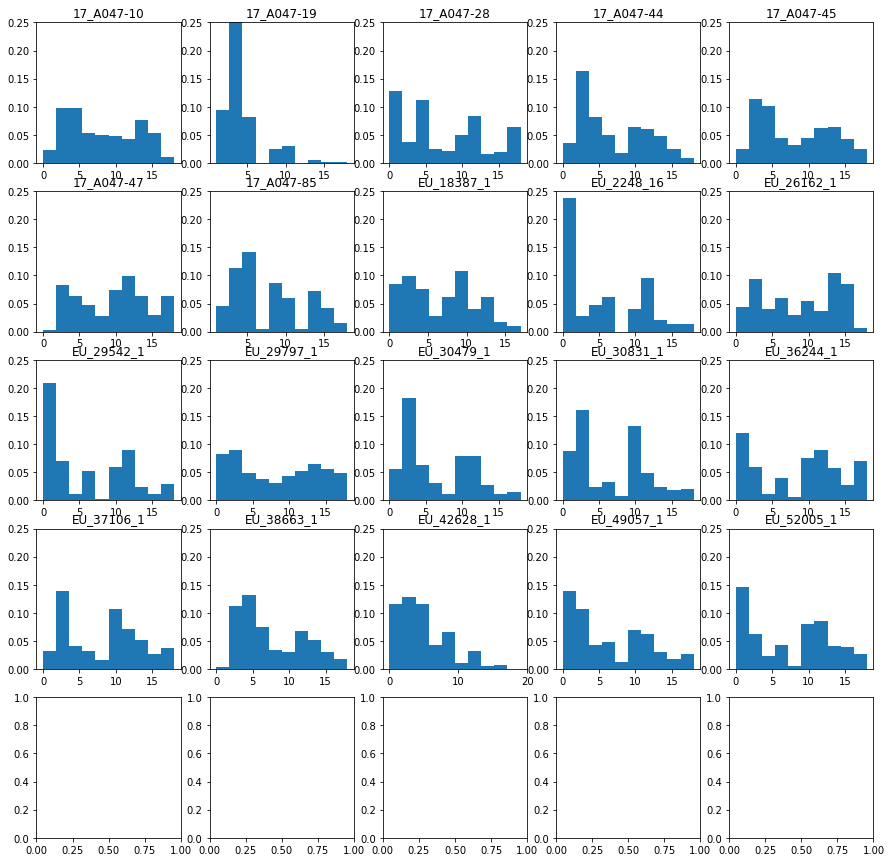

In [37]:
# Histogram for each slides
histograms = {}
fig, axes = plt.subplots(5, 5, figsize=(15,15))
axes = axes.flatten()  # so that one can iterate linearly over axes
for i, slide_id in enumerate(y.index.levels[0]):
    axes[i].set_ylim((0, 0.25))
    axes[i].set_title(slide_id[0:10])
    histograms[slide_id], bins, patches = axes[i].hist(y[slide_id], density=True)

In [38]:
# read in csv file
label_file = '/well/rittscher/projects/prostate-gland-phenotyping/WSI/data/other/TA206_Scores_V2_190718.csv'
labels = pd.read_csv(label_file, sep='\t')
labels = labels.set_index('file_name')

In [39]:
erg = labels['ERG H Score'].apply(lambda x: int(x) if x.isdigit() else 0)
erg = erg.apply(lambda x: int(x) > 0)
erg = erg.iloc[0::2]  # remove benign samples from spreadseet
erg.index = [s[:-5] for s in erg.index]

In [42]:
x_proportion = pd.DataFrame(np.array(list(v for v in histograms.values())), index=list(k for k in histograms.keys()))

In [43]:
x_proportion

,0,1,2,3,4,5,6,7,8,9
17_A047-10719_16L+-+2017-05-11+08.56.52,0.023425,0.097499,0.097499,0.054131,0.049383,0.048750,0.043052,0.076923,0.054131,0.010763
17_A047-19575_162E+-+2017-05-11+08.34.36,0.094118,0.345621,0.082614,0.000000,0.024575,0.030327,0.000523,0.005229,0.002614,0.002614
17_A047-28956_156N+-+2017-05-11+09.57.53,0.127473,0.038052,0.112253,0.024734,0.020928,0.049467,0.083714,0.015221,0.019026,0.064688
17_A047-4463_153D+-+2017-05-11+09.40.22,0.035571,0.164058,0.082568,0.049800,0.017678,0.063597,0.059932,0.048075,0.025439,0.008839
17_A047-4519_1614P+-+2017-05-11+09.50.49,0.024524,0.114129,0.101868,0.045274,0.031126,0.045274,0.062252,0.063196,0.043388,0.024524
17_A047-47800_15J+-+2017-05-11+08.12.44,0.003885,0.083528,0.064103,0.046620,0.027195,0.073815,0.099068,0.064103,0.029138,0.064103
17_A047-8544_16J+-+2017-05-11+08.49.27,0.046562,0.113301,0.141239,0.004656,0.086916,0.060531,0.004656,0.072947,0.041906,0.015521
EU_18387_14_1E_HandE,0.084399,0.099744,0.076726,0.028133,0.061381,0.107417,0.040921,0.061381,0.017903,0.010230
EU_2248_16_K_H&E,0.237127,0.027100,0.047425,0.060976,0.000000,0.040650,0.094851,0.020325,0.013550,0.013550
EU_26162_16_9x_HandE+-+2017-11-28+11.03.04,0.043771,0.094276,0.040404,0.060606,0.030303,0.053872,0.037037,0.104377,0.084175,0.006734


In [92]:
x_prop_pcaed = pd.DataFrame(PCA(n_components=2).fit_transform(x_proportion), index=x_proportion.index)
x_prop_pcaed['erg'] = [erg.loc[k] for k in x_prop_pcaed.index]
x_prop_pcaed['color_erg'] = x_prop_pcaed['erg'].map(lambda v: 'r' if v else 'b')

update_title_pos
update_title_pos
update_title_pos
update_title_pos
update_title_pos


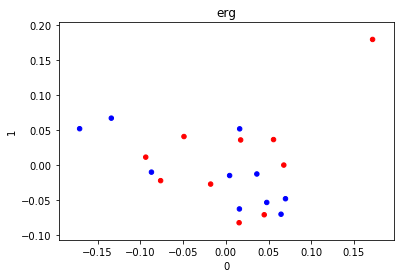

In [93]:
x_prop_pcaed.plot.scatter(x=0, y=1, c=x_prop_pcaed['color_erg'], title='erg')

In [94]:
# PTEN
pten = labels['PTEN H Score RESCORE BETTER STAINED TMA'].apply(lambda x: int(x) if x.isdigit() else 0)
pten = pten.apply(lambda x: int(x) > 0)
pten = pten.iloc[0::2]  # remove benign samples from spreadseet
pten.index = [s[:-5] for s in pten.index]

In [95]:
x_prop_pcaed['pten'] = [pten.loc[k] for k in x_prop_pcaed.index]
x_prop_pcaed['color_pten'] = x_prop_pcaed['pten'].map(lambda v: 'r' if v else 'b')

update_title_pos
update_title_pos
update_title_pos
update_title_pos
update_title_pos


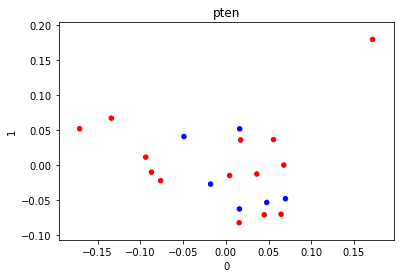

In [96]:
x_prop_pcaed.plot.scatter(x=0, y=1, c=x_prop_pcaed['color_pten'], title='pten')

In [97]:
proliferation = labels['Proliferation index Mib-1 0-100% (only invasive tumour scored, not PIN or intraductal Ca or inflammatory cells. In the benign, only luminal ep cells scored)'].apply(lambda x: int(x) if x.isdigit() else 0)
proliferation = proliferation.iloc[0::2]  # remove benign samples from spreadseet
proliferation.index = [s[:-5] for s in proliferation.index]
print(np.unique(proliferation))

[0 1 2 5 8]


In [98]:
x_prop_pcaed['proliferation'] = [proliferation.loc[k] for k in x_prop_pcaed.index]
x_prop_pcaed['color_proliferation'] = x_prop_pcaed['proliferation'].map(lambda k: {
    0: 'r', 1: 'b', 2: 'g', 5: 'y', 8: 'p'
}[k])

update_title_pos
update_title_pos
update_title_pos
update_title_pos
update_title_pos


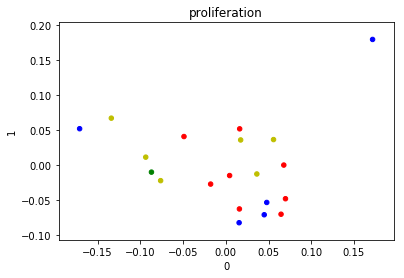

In [99]:
x_prop_pcaed.plot.scatter(x=0, y=1, c=x_prop_pcaed['color_proliferation'], title='proliferation')

In [106]:
# Gleason
gleason_file = '/well/rittscher/projects/prostate-gland-phenotyping/WSI/data/other/gleason.csv'
gleason = pd.read_csv(gleason_file, sep=',')
gleason_map = {'3+4': 0, '4+3': 1, '4+5': 2}
gleason['Gleason'] = gleason['Gleason'].map(lambda s: gleason_map[s])
gleason = gleason.set_index('file_id')
gleason.index = [s[:-5] for s in gleason.index]
print(np.unique(gleason['Gleason']))

[0 1 2]


In [107]:
x_prop_pcaed['gleason'] = [gleason['Gleason'].loc[k] for k in x_prop_pcaed.index]
x_prop_pcaed['color_gleason'] = x_prop_pcaed['gleason'].map(lambda k: {
    0: 'r', 1: 'b', 2: 'g'
}[k])

In [419]:
x_prop_pcaed['gleason'] == 1

17_A047-10719_16L+-+2017-05-11+08.56.52        True
17_A047-19575_162E+-+2017-05-11+08.34.36      False
17_A047-28956_156N+-+2017-05-11+09.57.53       True
17_A047-4463_153D+-+2017-05-11+09.40.22       False
17_A047-4519_1614P+-+2017-05-11+09.50.49      False
17_A047-47800_15J+-+2017-05-11+08.12.44       False
17_A047-8544_16J+-+2017-05-11+08.49.27        False
EU_18387_14_1E_HandE                          False
EU_2248_16_K_H&E                              False
EU_26162_16_9x_HandE+-+2017-11-28+11.03.04     True
EU_29542_16_1S_HandE+-+2017-11-28+12.49.46    False
EU_29797_14_5F_HandE+-+2017-11-28+13.15.48     True
EU_30479_16_G_HandE+-+2017-11-28+12.31.57     False
EU_30831_14_4D_HandE+-+2017-11-28+11.15.23    False
EU_36244_16_9A_HandE+-+2017-11-28+12.41.47     True
EU_37106_15_2K_HandE+-+2017-11-28+11.43.55    False
EU_38663_17_7G_HandE+-+2017-11-28+11.48.55     True
EU_42628_15_4J_HandE+-+2017-11-28+12.20.38    False
EU_49057_14_2F_HandE+-+2017-11-28+10.42.55    False
EU_52005_15_

update_title_pos
update_title_pos
update_title_pos
update_title_pos
update_title_pos


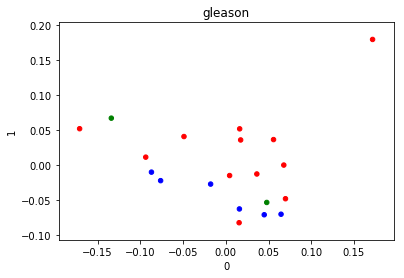

In [179]:
ax = x_prop_pcaed.plot.scatter(x=0, y=1, c=x_prop_pcaed['color_gleason'], title='gleason')

Text(0, 0.5, 'Second principal component')

update_title_pos
update_title_pos
update_title_pos
update_title_pos
update_title_pos


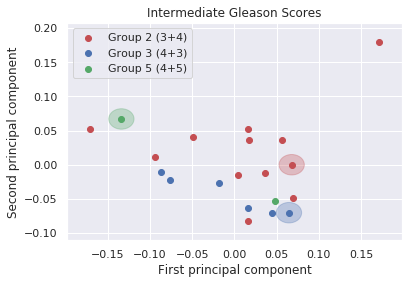

In [442]:
clrs = {0: 'r', 1: 'b', 2: 'g'}
sns.set_palette('bright')
for v in np.unique(x_prop_pcaed['gleason']):
    xx = x_prop_pcaed[x_prop_pcaed['gleason'] == v].iloc[:, 0]
    yy = x_prop_pcaed[x_prop_pcaed['gleason'] == v].iloc[:, 1]
    plt.scatter(xx, yy, c=clrs[v], label=['Group 2 (3+4)', 'Group 3 (4+3)', 'Group 5 (4+5)'][v])
ax = plt.gca()
ax.legend()
ax.set_title('Intermediate Gleason Scores')
circle_34 = plt.Circle(
    tuple(x_prop_pcaed.loc['17_A047-4463_153D+-+2017-05-11+09.40.22'].iloc[0:2]), 
    0.015, color='r', alpha=0.3)
circle_43 = plt.Circle(
    tuple(x_prop_pcaed.loc['EU_38663_17_7G_HandE+-+2017-11-28+11.48.55'].iloc[0:2]), 
    0.015, color='b', alpha=0.3)
circle_45 = plt.Circle(
    tuple(x_prop_pcaed.loc['EU_29542_16_1S_HandE+-+2017-11-28+12.49.46'].iloc[0:2]), 
    0.015, color='g', alpha=0.3)
ax.add_artist(circle_45)
ax.add_artist(circle_34)
ax.add_artist(circle_43)
ax.set_xlabel('First principal component')
ax.set_ylabel('Second principal component')

update_title_pos
update_title_pos
update_title_pos
update_title_pos
update_title_pos
update_title_pos
update_title_pos
update_title_pos
update_title_pos
update_title_pos
update_title_pos
update_title_pos
update_title_pos
update_title_pos
update_title_pos


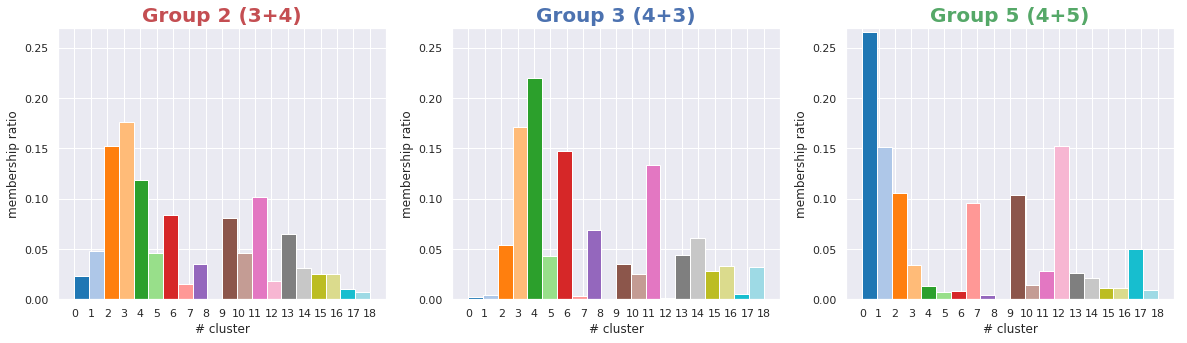

In [443]:
from matplotlib import cm
fig, axes = plt.subplots(1, 3, figsize=(20, 5))
ids =  ['17_A047-4463_153D+-+2017-05-11+09.40.22', 'EU_38663_17_7G_HandE+-+2017-11-28+11.48.55',
        'EU_29542_16_1S_HandE+-+2017-11-28+12.49.46']
colors = ['r', 'b', 'g']
gl = ['Group 2 (3+4)', 'Group 3 (4+3)', 'Group 5 (4+5)']
for i, ax, id_ in zip([0, 1, 2], axes, ids):
    N, bins, patches = axes[i].hist(y[id_], density=True, bins=20) #color=colors[i])
    for p, patch in enumerate(patches):
        patch.set_facecolor(cm.tab20(p))
    axes[i].set_ylim((0, 0.27))
    axes[i].set_xlim((-1, 19))
    axes[i].set_xticks(list(range(19)))
    axes[i].set_title(gl[i], color=colors[i], fontsize=20, fontweight='bold')
    axes[i].set_ylabel('membership ratio')
    axes[i].set_xlabel('# cluster')

In [276]:
print(len(np.histogram(y[id_])[0]))
print(np.unique(y))

10
[ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19]


In [126]:
# manual annotation results:
# read in csv file
ma_file = '/well/rittscher/projects/prostate-gland-phenotyping/WSI/data/other/manual_results.compiled.csv'
manual_annotations = pd.read_csv(ma_file, sep=',', header=[0, 1])
manual_annotations = manual_annotations.set_index('file_id')
manual_annotations.index = [k[0][:-5] for k in manual_annotations.index]

In [142]:
x_prop_pcaed['tumor_til1'] = [manual_annotations['% TILs in tumour']['Observer 1 '].loc[k] for k in x_prop_pcaed.index]
print(np.unique(x_prop_pcaed['tumor_til1']))
x_prop_pcaed['tumor_til1'] = x_prop_pcaed['tumor_til1'].map(lambda x: {
   0: 0, 10: 0, 20: 0, 30: 1, 40: 1, 50: 2, 60: 2 
}[x])
x_prop_pcaed['color_tumor_til1'] = x_prop_pcaed['tumor_til1'].map(lambda x: {
   0: 'r', 1: 'b', 2: 'g' 
}[x])

[ 0 10 20 30 40 50 60]


update_title_pos
update_title_pos
update_title_pos
update_title_pos
update_title_pos


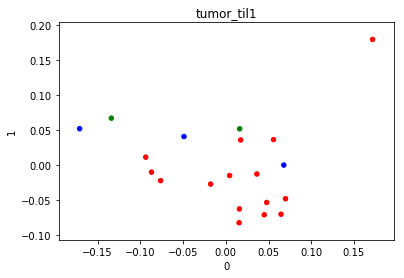

In [143]:
x_prop_pcaed.plot.scatter(x=0, y=1, c=x_prop_pcaed['color_tumor_til1'], title='tumor_til1')

In [144]:
x_prop_pcaed['tumor_til2'] = [manual_annotations['% TILs in tumour']['Observer 2'].loc[k] for k in x_prop_pcaed.index]
print(np.unique(x_prop_pcaed['tumor_til2']))
x_prop_pcaed['tumor_til2'] = x_prop_pcaed['tumor_til2'].map(lambda x: {
   0: 0, 10: 0, 20: 1, 30: 1, 40: 2
}[x])
x_prop_pcaed['color_tumor_til2'] = x_prop_pcaed['tumor_til2'].map(lambda x: {
   0: 'r', 1: 'b', 2: 'g' 
}[x])

[ 0 10 20 30 40]


update_title_pos
update_title_pos
update_title_pos
update_title_pos
update_title_pos


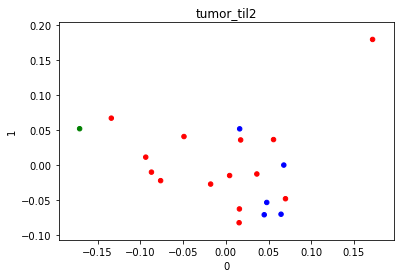

In [145]:
x_prop_pcaed.plot.scatter(x=0, y=1, c=x_prop_pcaed['color_tumor_til2'], title='tumor_til2')

In [152]:
# gland formation
s = 'gland_formation1'
x_prop_pcaed[s] = [manual_annotations['% gland formation']['Observer 1 '].loc[k] for k in x_prop_pcaed.index]
print(np.unique(x_prop_pcaed[s]))
x_prop_pcaed[s] = x_prop_pcaed[s].map(lambda x: 0 if x <= 80 else 1)
x_prop_pcaed[f'color_{s}'] = x_prop_pcaed[s].map(lambda x: {
   0: 'r', 1: 'b'
}[x])

[ 20  50  70  80  90 100]


update_title_pos
update_title_pos
update_title_pos
update_title_pos
update_title_pos


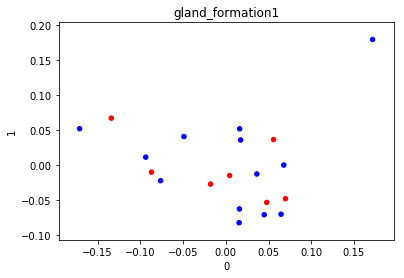

In [153]:
x_prop_pcaed.plot.scatter(x=0, y=1, c=x_prop_pcaed[f'color_{s}'], title=s)

In [164]:
# gland formation
s = 'gland_formation2'
x_prop_pcaed[s] = [manual_annotations['% gland formation']['Observer 2'].loc[k] for k in x_prop_pcaed.index]
print(np.unique(x_prop_pcaed[s]))
x_prop_pcaed[s] = x_prop_pcaed[s].map(lambda x: 0 if x <= 80 else 1)
x_prop_pcaed[f'color_{s}'] = x_prop_pcaed[s].map(lambda x: {
   0: 'r', 1: 'b'
}[x])

[ 60  80  90 100]


update_title_pos
update_title_pos
update_title_pos
update_title_pos
update_title_pos


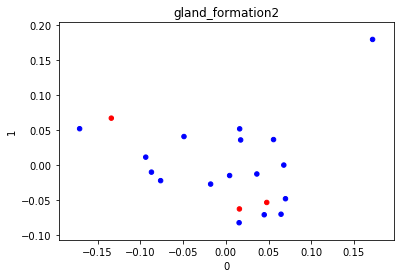

In [165]:
x_prop_pcaed.plot.scatter(x=0, y=1, c=x_prop_pcaed[f'color_{s}'], title=s)

In [226]:
# Univariate feature analysis
x2 = SelectKBest(chi2, k=2).fit_transform(x_proportion, x_prop_pcaed['gleason'])
x2 = PCA(n_components=2).fit_transform(x2)

Text(0.5, 1.0, 'Intermediate Gleason Scores')

update_title_pos
update_title_pos
update_title_pos
update_title_pos
update_title_pos


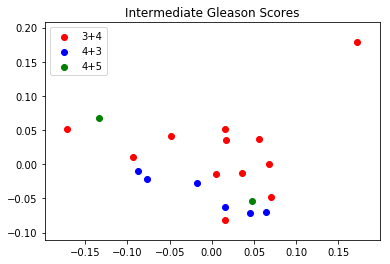

In [225]:
clrs = {0: 'r', 1: 'b', 2: 'g'}
for v in np.unique(x_prop_pcaed['gleason']):
    xx = x2[x_prop_pcaed['gleason'] == v][:, 0]
    yy = x2[x_prop_pcaed['gleason'] == v][:, 1]
    plt.scatter(xx, yy, c=clrs[v], label=['3+4', '4+3', '4+5'][v])
ax = plt.gca()
ax.legend()
ax.set_title('Intermediate Gleason Scores')

In [212]:
# Univariate feature analysis
x2 = SelectKBest(chi2, k=2).fit_transform(x_proportion, x_prop_pcaed['pten'])
#x2 = PCA(n_components=2).fit_transform(x2)

/well/rittscher/users/achatrian/.conda/envs/pyenvclone/lib/python3.7/site-packages/ipykernel_launcher.py:5: DeprecationWarning: In future, it will be an error for 'np.bool_' scalars to be interpreted as an index
  """


Text(0.5, 1.0, 'PTEN')

update_title_pos
update_title_pos
update_title_pos
update_title_pos
update_title_pos


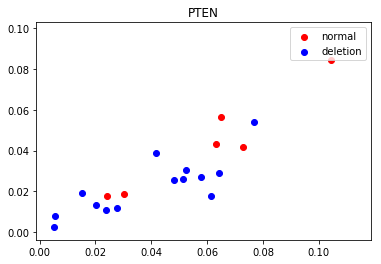

In [213]:
clrs = {0: 'r', 1: 'b', 2: 'g'}
for v in np.unique(x_prop_pcaed['pten']):
    xx = x2[x_prop_pcaed['pten'] == v][:, 0]
    yy = x2[x_prop_pcaed['pten'] == v][:, 1]
    plt.scatter(xx, yy, c=clrs[v], label=['normal', 'deletion'][v])
ax = plt.gca()
ax.legend()
ax.set_title('PTEN')

update_title_pos
update_title_pos
update_title_pos
update_title_pos
update_title_pos
update_title_pos
update_title_pos
update_title_pos
update_title_pos
update_title_pos
update_title_pos
update_title_pos
update_title_pos
update_title_pos
update_title_pos


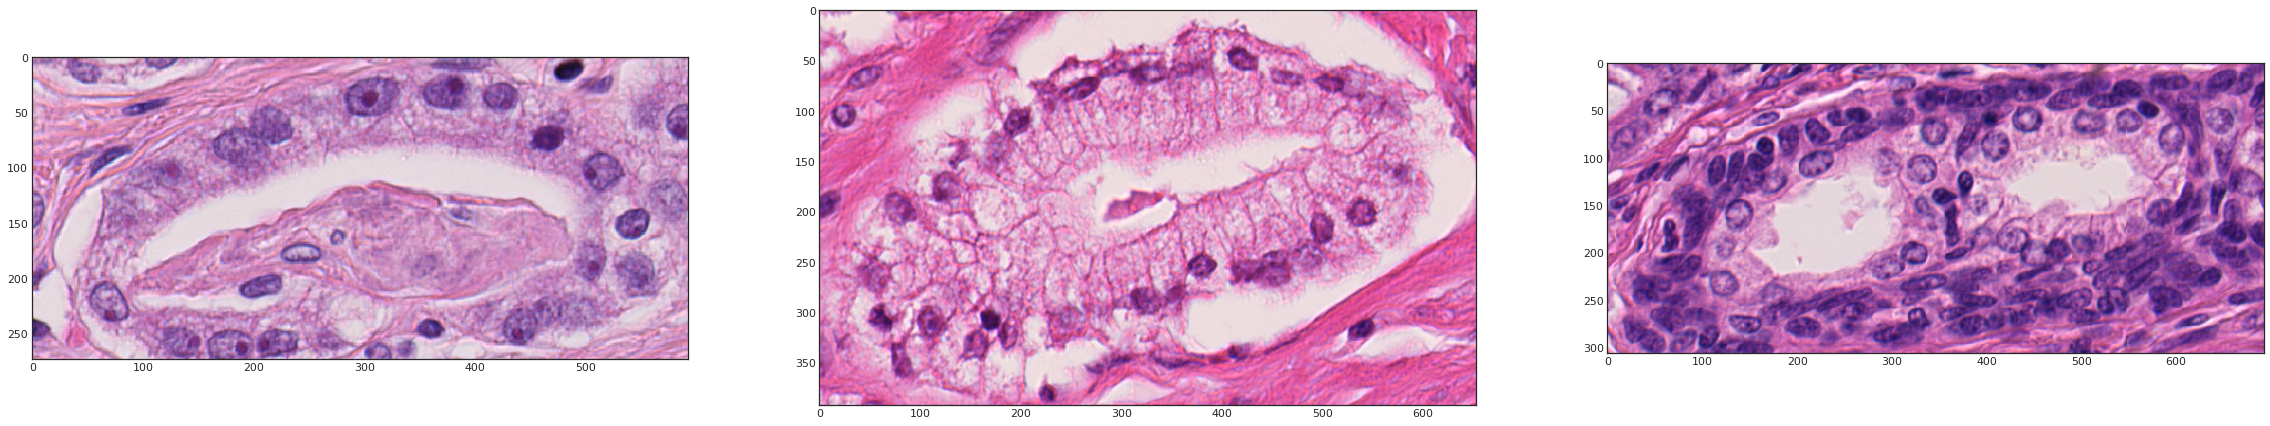

In [402]:
# Gland plot showing subset of clusters

cluster_num = 11
example0_num = 1
example1_num = 3
example2_num = 7
fig, axes = plt.subplots(1, 3, figsize=(40, 40))
for ax in axes:
    ax.tick_params(axis=u'both', which=u'both',length=0)
axes[0].imshow(examples[cluster_num][example0_num])
axes[1].imshow(examples[cluster_num][example1_num])
axes[2].imshow(examples[cluster_num][example2_num])
#plt.grid(False)